In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
import statistics
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, RocCurveDisplay
from joblib import dump, load

In [8]:
# Einlesen der Daten
df = pd.read_csv("train.csv")

# Spalte Index nicht aussagekräftig --> Wird gelöscht
df = df.drop(columns="index")

# Skalierung von CO2, da rechtsschiefe Verteilung + von allen anderen, da SVM sensitiv auf Skalierung reagiert
scaler= MinMaxScaler()
df[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt"]]=scaler.fit_transform(df[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt"]])

# Auffüllen NaN-Werte
df.fillna(method="ffill", inplace= True)

# Operationen auf Datumsspalte
df["Datum"]=pd.to_datetime(df["Datum"])
df["Tag"]=df["Datum"].dt.day.astype(str)
df["Uhrzeit"]=df["Datum"].dt.hour.astype(str)
df_modified = df.drop(columns="Datum",axis=1)

# Teile Daten in Features und Label auf
X = df_modified.drop(columns=["Anwesenheit"])
y = df_modified[["Anwesenheit"]].values.reshape(-1,1)
y = np.ravel(y)


In [3]:
df_modified

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit,Tag,Uhrzeit
0,0.772881,0.470533,0.190933,0.557318,1,25,17
1,0.767334,0.470332,0.186446,0.554807,1,25,17
2,0.767334,0.469326,0.186136,0.553761,1,25,17
3,0.767334,0.467315,0.182887,0.551669,1,25,17
4,0.758089,0.467315,0.180566,0.547851,1,25,17
...,...,...,...,...,...,...,...
14236,0.203390,0.752933,0.057094,0.582947,0,3,23
14237,0.184900,0.748910,0.056785,0.571493,0,3,23
14238,0.184900,0.748910,0.054309,0.571493,0,3,23
14239,0.184900,0.748910,0.055238,0.571493,0,3,23


# Training auf Ausschnitt des Datensatzes, da lange Laufzeit

In [9]:
# Training auf 10 % des Datensatzes
df_sampled = df_modified.sample(frac=0.1)
df_sampled

# Teile Daten in Features und Label auf
X_sampled = df_sampled.drop(columns=["Anwesenheit"],axis=1)
y_sampled = df_sampled[["Anwesenheit"]]
y_sampled = np.ravel(y_sampled)

In [10]:
# Training und Testset der sampled data 
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [6]:
# Parameter mit Cross validation setzen
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]


# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
clf_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Fitten der SVC auf de
clf_sampled.fit(X_s_train, y_s_train)

best_parameters_sampled = clf_sampled.best_params_
print(best_parameters_sampled)

best_result = clf_sampled.best_score_
print(best_result)

y_s_true, y_s_pred = y_s_test, clf_sampled.predict(X_s_test)
print(classification_report(y_s_true, y_s_pred))

# C und gamma anders hierbei, Recall geringer als bei erstem SVM 

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.946271186440678
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       209
           1       0.88      0.92      0.90        76

    accuracy                           0.94       285
   macro avg       0.92      0.94      0.93       285
weighted avg       0.95      0.94      0.94       285



In [7]:
# GridSearch mit vorherigem SMOTE

# define oversampling strategy
#SMOTE = SMOTE()

# fit and apply the transformation
X_s_train_SMOTE, y_s_train_SMOTE = SMOTE().fit_resample(X_s_train, y_s_train)

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]


# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
# GridSearchCV, um die besten Hyperparameter zu finden, wodurch Recall maximal ist
clf_SMOTE_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Trainiere SVM
clf_SMOTE_sampled.fit(X_s_train_SMOTE, y_s_train_SMOTE)

best_parameters_sampled_SMOTE = clf_SMOTE_sampled.best_params_
print(best_parameters_sampled_SMOTE)

best_result_SMOTE = clf_SMOTE_sampled.best_score_
print(best_result_SMOTE)

y_s_true_SMOTE, y_s_pred_SMOTE = y_s_test, clf_SMOTE_sampled.predict(X_s_test)
print(classification_report(y_s_true_SMOTE, y_s_pred_SMOTE))

# Mit SMOTE: Bekomme besseres Ergebnis als ohne!
# Ist mit dem Ergebnis des Durchlaufs auf ganzem Datensatz identisch

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.9894736842105264
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       222
           1       0.78      0.94      0.85        63

    accuracy                           0.93       285
   macro avg       0.88      0.93      0.90       285
weighted avg       0.94      0.93      0.93       285



# Training auf ganzem Datensatz

In [11]:
# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Upsampling mit SMOTE

In [15]:
# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({1: 8472, 0: 8472})


## Hyperparameter Suche mit exhaustive GridSearchCV - rein auf recall fokussiert

In [11]:
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1,0.5, 1], "C": [1, 10,100,1000]},
    #{"kernel": ["linear"], "C": [1, 10]},
    #{"kernel": ["poly"],"C": [1, 10]}
]



clf_SMOTE = GridSearchCV(SVC(), tuned_parameters, scoring="recall")
clf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
best_parameters = clf_SMOTE.best_params_
print(best_parameters)
best_result = clf_SMOTE.best_score_
print(best_result)

y_true, y_pred = y_test, clf_SMOTE.predict(X_test)
print(classification_report(y_true, y_pred))

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
0.9924460093406191
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2116
           1       0.97      0.99      0.98       733

    accuracy                           0.99      2849
   macro avg       0.98      0.99      0.99      2849
weighted avg       0.99      0.99      0.99      2849



In [4]:
dump(clf_SMOTE, 'svm.joblib') 

['svm.joblib']

In [3]:
# Nutzen des Modells
clf_SMOTE = load('svm.joblib') 

/Users/lenasommer/opt/anaconda3/envs/Machine_Learning/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lenasommer/opt/anaconda3/envs/Machine_Learning/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
# Training des Modells mit den herausgefundenen Parametern 
clf_best = SVC(C=1000, gamma=1,kernel="rbf")
clf_best.fit(X_train_SMOTE, y_train_SMOTE)

SVC(C=1000, gamma=1)

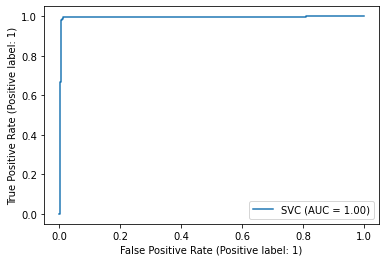

In [17]:
# ROC-Kurve
svc_disp = RocCurveDisplay.from_estimator(clf_best, X_test, y_test)
plt.show()


# Testen 

## Funktion, welche alle Schritte zum Vorbereiten der Daten reproduziert

In [27]:
df_test = pd.read_csv("test.csv")
df_test = df_test.drop(columns="index")
    
scaler= MinMaxScaler()
df_test[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt"]]=scaler.fit_transform(df_test[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt"]])
df_test.fillna(method="ffill", inplace= True)
    
df_test["Datum"]=pd.to_datetime(df_test["Datum"])
df_test["Tag"]=df_test["Datum"].dt.day.astype(str)
df_test["Uhrzeit"]=df_test["Datum"].dt.hour.astype(str)
df_test = df_test.drop(columns="Datum",axis=1)
df_test

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Tag,Uhrzeit
0,0.145119,0.608481,0.008998,0.586332,4,0
1,0.140721,0.613851,0.007945,0.589491,4,0
2,0.131926,0.611440,0.008051,0.582376,4,0
3,0.131926,0.615056,0.007419,0.586062,4,0
4,0.131926,0.613851,0.007524,0.584833,4,0
...,...,...,...,...,...,...
6314,0.346966,0.225345,0.639305,0.284980,8,9
6315,0.360158,0.227153,0.645146,0.292929,8,9
6316,0.366755,0.227153,0.649566,0.295942,8,9
6317,0.366755,0.245398,0.719337,0.315553,8,9


In [48]:
# Prediction
test_pred = clf_SMOTE.predict(df_test)
df_pred = pd.DataFrame(test_pred)
df_pred = df_pred.rename(columns={0:"Vorhergesagte_Anwesenheit"})
df_pred

,Vorhergesagte_Anwesenheit
0,0
1,0
2,0
3,0
4,0
...,...
6314,0
6315,0
6316,0
6317,0
